# Testing - Single leaf image: feature extraction and preprocessing

This file explores the techniques to be used for preprocessing and feature extraction for the Flavia leaves dataset images.

### Importing necessary libraries

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Reading the image

###### Note: 'Flavia leaves dataset' should be in the project root containing Flavia images.

In [2]:
ds_path = "Flavia leaves dataset"

In [3]:
test_img_path = ds_path + "/2540.jpg"
test_img_path

'Flavia leaves dataset/2540.jpg'

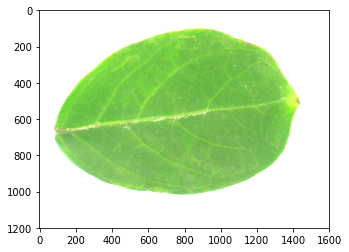

In [4]:
main_img = cv2.imread(test_img_path)
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Converting image to grayscale

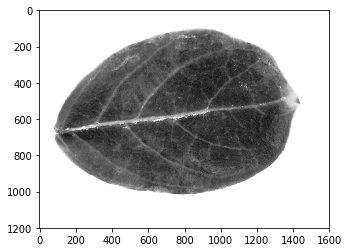

In [5]:
gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gs,cmap='Greys_r')

In [6]:
gs.shape

(1200, 1600)

### Smoothing image using Guassian filter of size (25,25)

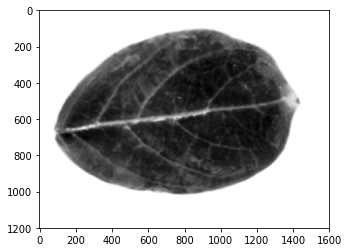

In [6]:
blur = cv2.GaussianBlur(gs, (25,25),0)
plt.imshow(blur,cmap='Greys_r')

### Adaptive image thresholding using Otsu's thresholding method

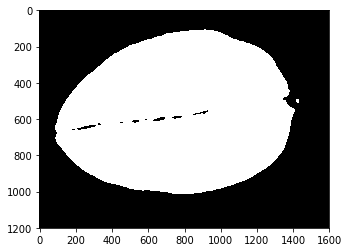

In [7]:
ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(im_bw_otsu,cmap='Greys_r')

### Closing of holes using Morphological Transformation

Performed so as to close any holes present in the leaf

In [8]:
kernel = np.ones((50,50),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

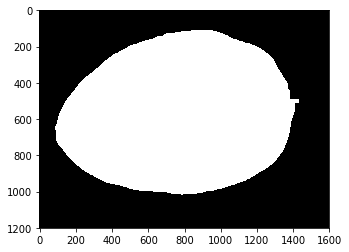

In [9]:
plt.imshow(closing,cmap='Greys_r')

# Boundary extraction

Boundary extraction is needed which will be used in calculation of shape features.

### Boundary extraction using sobel filters - Not effective

Trying to extract the boundary of the leaf using sobel filters. The image after edge extraction is thresholded using Otsu's method. Then the gaps were closed using Closing operation of Morphological Transformation.

This method is not effective as even after performing morphological transformation, gaps still persist.

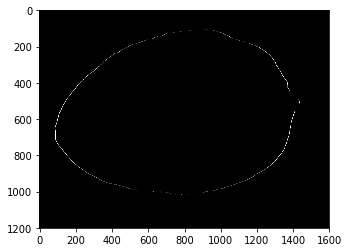

In [10]:
sobelx64f = cv2.Sobel(closing,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
plt.imshow(abs_sobel64f,cmap='Greys_r')

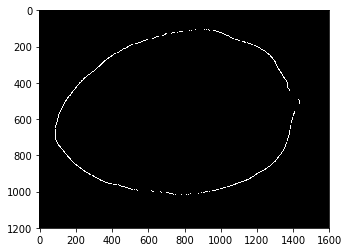

In [11]:
ret_sobel,im_bw_sobel = cv2.threshold(sobel_8u,1,255,cv2.THRESH_BINARY)
plt.imshow(im_bw_sobel,cmap='Greys_r')

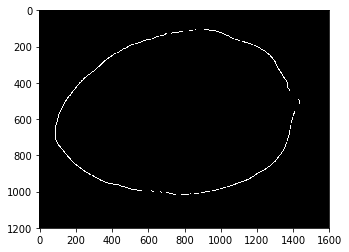

In [12]:
kernel_edge = np.ones((15,15),np.uint8)
closing_edge = cv2.morphologyEx(im_bw_sobel, cv2.MORPH_CLOSE, kernel_edge)
plt.imshow(closing_edge,cmap='Greys_r')

### Boundary extraction using contours - Effective 

Contours are used to extract leaf boundaries. They are continous, sharp and there are no gaps between the boundary pixels

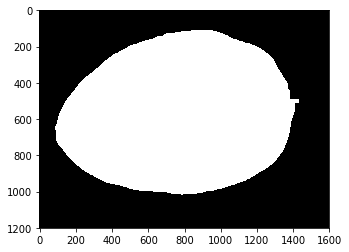

In [13]:
plt.imshow(closing,cmap="Greys_r")

In [14]:
_, contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [15]:
len(contours)

1

In [16]:
cnt = contours[0]
len(cnt)

1534

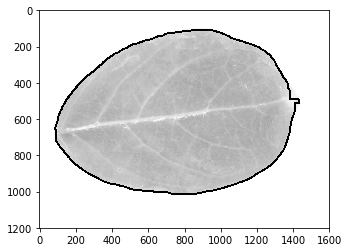

In [17]:
plottedContour = cv2.drawContours(gs,contours,-1,(0,255,0),10)
plt.imshow(plottedContour,cmap="Greys_r")

## Morphological processing

## 1. Shape based features

### Calculating moments using contours

In [18]:
M = cv2.moments(cnt)
M

{'m00': 910721.0,
 'm01': 524665692.3333333,
 'm02': 347990886869.8333,
 'm03': 252474241294221.9,
 'm10': 703224634.8333333,
 'm11': 398227946150.3333,
 'm12': 261528153642954.0,
 'm20': 640031896450.0,
 'm21': 359321159856831.4,
 'm30': 642006680853457.6,
 'mu02': 45731370825.27527,
 'mu03': -694668016140.5938,
 'mu11': -6899244175.448425,
 'mu12': 771927641149.3047,
 'mu20': 97028180672.638,
 'mu21': 1253934949813.6328,
 'mu30': -2045021596419.0,
 'nu02': 0.05513704893662721,
 'nu03': -0.0008776349832246818,
 'nu11': -0.008318227878644622,
 'nu12': 0.0009752438382791831,
 'nu20': 0.11698419376972494,
 'nu21': 0.0015842059128598205,
 'nu30': -0.0025836550017642604}

In [19]:
area = cv2.contourArea(cnt)
area

910721.0

In [20]:
perimeter = cv2.arcLength(cnt,True)
perimeter

3771.909057736397

### Fitting in the best-fit rectangle and ellipse

The best-fit rectangle is chosen and not ellipse as removes (leaves out) some portion at the extreme ends of the leaf image.

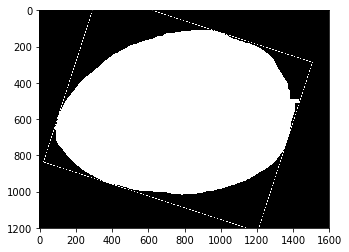

In [21]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
contours_im = cv2.drawContours(closing,[box],0,(255,255,255),2)
plt.imshow(contours_im,cmap="Greys_r")

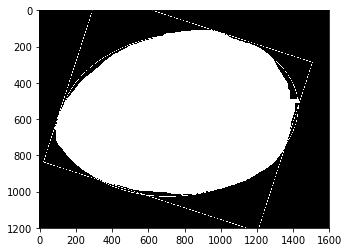

In [22]:
ellipse = cv2.fitEllipse(cnt)
im = cv2.ellipse(closing,ellipse,(255,255,255),2)
plt.imshow(closing,cmap="Greys_r")

### Shape based features calculated - Aspect ratio, rectangularity, circularity etc.

In [23]:
x,y,w,h = cv2.boundingRect(cnt)
aspect_ratio = float(w)/h
aspect_ratio

1.4856828193832599

In [24]:
rectangularity = w*h/area
rectangularity

1.3449695351265645

In [25]:
circularity = ((perimeter)**2)/area
circularity

15.622015897112147

In [26]:
equi_diameter = np.sqrt(4*area/np.pi)
equi_diameter

1076.831459152616

In [27]:
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)

## 2. Color based features

### Calculating color based features - mean, std-dev of the RGB channels

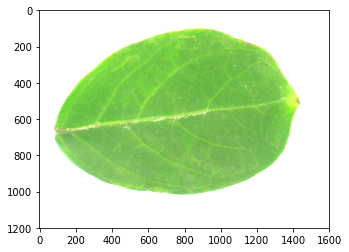

In [28]:
plt.imshow(img,cmap="Greys_r")

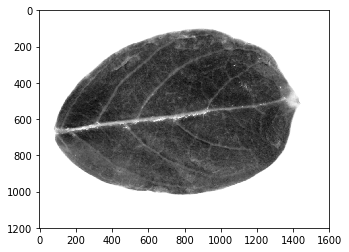

In [29]:
red_channel = img[:,:,0]
plt.imshow(red_channel,cmap="Greys_r")

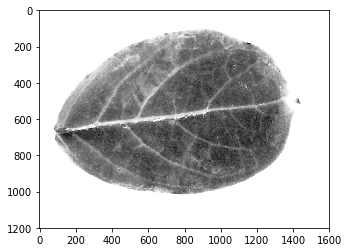

In [30]:
green_channel = img[:,:,1]
plt.imshow(green_channel,cmap="Greys_r")

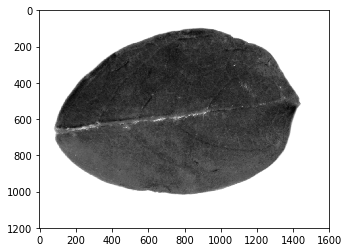

In [31]:
blue_channel = img[:,:,2]
plt.imshow(blue_channel,cmap="Greys_r")

In [32]:
np.mean(blue_channel)

170.973146875

In [33]:
blue_channel[blue_channel == 255] = 0
green_channel[green_channel == 255] = 0
red_channel[red_channel == 255] = 0

In [34]:
red_mean = np.mean(red_channel)
red_mean

62.887436979166665

In [35]:
green_mean = np.mean(green_channel)
green_mean

96.01955729166667

In [36]:
blue_mean = np.mean(blue_channel)
blue_mean

41.8516390625

In [37]:
red_var = np.std(red_channel)
red_var

66.04808380928877

## 3. Texture based features 

### Using Haralick moments - calculating texture based features such as contrast, correlation, entropy

In [39]:
import mahotas as mt

In [40]:
textures = mt.features.haralick(gs)
ht_mean = textures.mean(axis=0)
ht_mean

array([ 2.56316916e-01,  1.35171665e+02,  9.78099847e-01,  3.08603445e+03,
        7.39821097e-01,  4.12842163e+02,  1.22089661e+04,  4.22864291e+00,
        5.23452308e+00,  1.69217553e-03,  1.76356916e+00, -5.96235431e-01,
        9.94013541e-01])

In [41]:
print(ht_mean[1]) #contrast
print(ht_mean[2]) #correlation
print(ht_mean[4]) #inverse difference moments
print(ht_mean[8]) #entropy

135.1716647951232
0.9780998471532103
0.7398210969650316
5.234523084644909
